# Deep Learning for Predictive Maintenance

This is the skeleton code file for the EEC4400 assignment. Replace the XX in the name of this notebook with your group number (this is important for correct marks to be awarded to your group). Fill in the blank cells below with the necessary code (you should work on this notebook section by section). At the end, the entire notebook should generate all the required results and execute without error.

The text above the blank cells provide some information on the functionality that needs to be implemented. You need to write Python code at places indicated by "[WriteCode]".

In this notebook, we explore the following:

1. CNN 1D and LSTM models
2. Two types of prediction tasks
  
  a. Binary Classification :  determining if a machine will fail in a given "w1" window period (Yes/No)

  b. Regression : predicting the remaining time a machine can run before failing (RUL)


In [107]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow import keras # make sure you use TensorFlow Keras
import seaborn as sns
import warnings
import os
import time
%matplotlib inline

from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten, BatchNormalization, LayerNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from kerastuner.tuners import RandomSearch
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.regularizers import l1
# Extra imports must be done by students
# [WriteCode] from ... import ...
# [WriteCode] from ... import ...
# [WriteCode] from ... import ...

# Setting seed for reproducibility (uncomment and use if needed)
# np.random.seed(xx)  
# PYTHONHASHSEED = x

## Setting up TensorBoard

In [108]:
def get_run_logdir(k):
  root_logdir = os.path.join(os.curdir, "eec4400_logs", k)
  run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
  return os.path.join(root_logdir, run_id)

## Initialize model parameters

Use the form below to enter parameter values before re-running the notebook. 

Use the same no. of epochs (ep) and batch size (ba) values for all the baseline CNN-Bin, LSTM-Bin, CNN-RUL and LSTM-RUL models.

Create additional variables and fields in this form as you require.

In [109]:
# Input Parameters
sequence_length = 25 # length of each sequence of values
ep =  5 # epochs
ba =  100 # batch_size                 

In [110]:
# DO NOT CHANGE the settings in this cell
w1 = 30 # window size before failure classification

## Data Ingestion
In the following section, 
- We ingest the training, test and ground truth datasets
- We provide column headings for consistency

(*Note*: training, test and ground truth dataframes are named "train_df", "test_df", and "truth_df" correspondingly. This naming is used consistently throughout the skeleton file.)

In [111]:
# Data ingestion

# read training data 
train_df = pd.read_csv('PM_train-2024.txt', sep=" ", header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read test data
test_df = pd.read_csv('PM_test-2024.txt', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data
truth_df = pd.read_csv('PM_truth-2024.txt', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

# final Training data
train_df = train_df.sort_values(['id','cycle'])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,522.31,2388.01,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,522.42,2388.03,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,522.03,2388.00,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,522.49,2388.08,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,522.58,2388.03,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583


## Data Exploration

Understanding the underlying characteristics of the dataset:
- Plot cross-correlation heatmap to understand correlation between sensor readings in training data (use seaborn package)
- Observe the data characteristics of three machines with shortest, average and longest operating lifetime (code provided)

(*Note*: use the results to answer the Data Exploration question Section 7 of the assignment document)

### Cross-correlation Heatmap

Expected result:

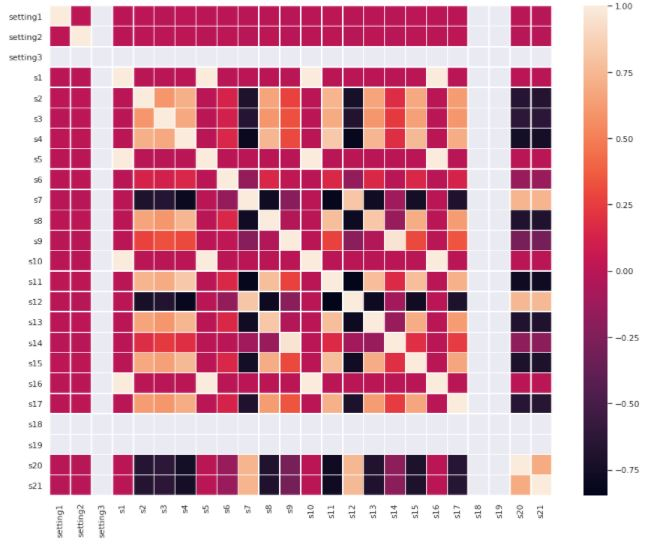

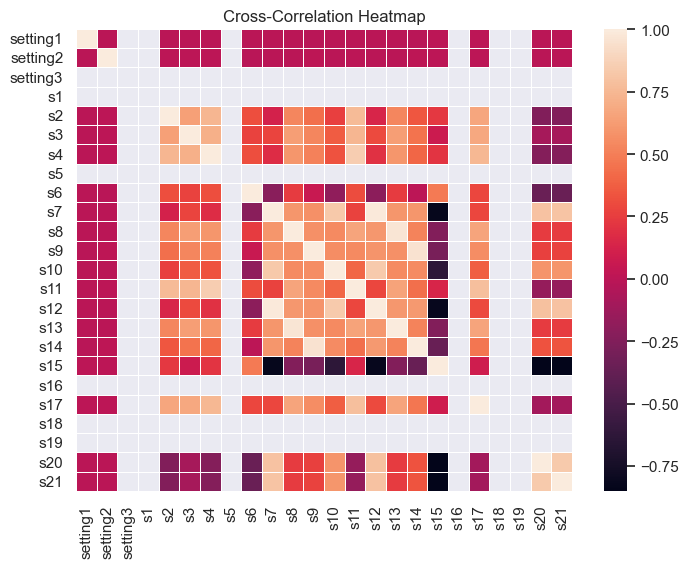

In [112]:
# Cross-correlation HeatMap

sns.set() 
def labels(x, y, *axes):
    for axis in axes:
        if x: axis.set_xlabel(x)
        if y: axis.set_ylabel(y)

df_sub = train_df.copy()
del df_sub['id']

df_sub.set_index('cycle', inplace=True)

# [WriteCode] to determine Pearson correlation and save in dataframe df_corr
# [WriteCode] for plotting cross-correlation heatmap using seaborn
# df_sub.head()

df_corr = df_sub.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr, linewidths=0.1, linecolor='white')
plt.title("Cross-Correlation Heatmap")
plt.show()

### Shortest, Average and Longest machine lifetimes

In [113]:
# Some Plotting Functions

mapp = {}
for id_num in train_df['id'].unique():
    mapp[id_num] = train_df['cycle'].loc[train_df['id'] == id_num].max()
mapp_len = sorted(mapp.items(), key=lambda kv: kv[1])
wind_size = w1

def exclude_trivial(df_sub):
    cols = []
    for col in df_sub.columns:
        if col == 'id':
            continue
        elif col == 'RUL':
            continue
        elif len(df_sub[col].unique()) <= 2:
            continue
        else:
            cols.append(col)
    return df_sub[cols].copy()

def get_data_non_trivial(df, unit_num, ):
    df_sub = df.loc[df['id'] == unit_num].copy()
    df_sub.set_index('cycle', inplace=True)
    df_sub.dropna(axis=1, how='all', inplace=True)
    df_sub = exclude_trivial(df_sub)
    return df_sub

def get_data_by_cols_and_unit(df, unit_num, cols):
    df_sub = df.loc[df['id'] == unit_num].copy()
    df_sub.set_index('cycle', inplace=True)
    df_sub.dropna(axis=1, how='all', inplace=True)
    df_sub = df_sub[cols]
    return df_sub

def plot_ts(df, unit_num, wind_size):
    '''plot all non trivial measurements and states'''
    df_sub = get_data_non_trivial(df, unit_num)
    cols = df_sub.columns
    fig, axes = plt.subplots(len(cols), 1, figsize=(15,12))
    for col, ax in zip(cols, axes):
        df_sub[col].plot(ax = ax)
        df_sub[col].rolling(wind_size).median().plot(ax = ax)
        df_sub[col].rolling(wind_size).mean().plot(style = '--', legend=True, ax = ax)
    fig.suptitle('unit NUM: {}'.format(unit_num))

def plot_hist(df, unit_num, wind_size):
    '''plot all non trivial measurements and states'''
    df_sub = get_data_non_trivial(df, unit_num)
    cols = df_sub.columns
    n_cols = min(len(cols), 5)
    n_rows = int(np.ceil(len(cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,12))
    axes = axes.flatten()
    for col, ax in zip(cols, axes):
        sns.distplot(df_sub[[col]], ax=ax, label=col)
        labels(col, "p", ax)
    fig.suptitle('unit NUM: {}'.format(unit_num))
    
def plot_learn(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.ylim((0, 0.1))
    plt.xlim((1, ep))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

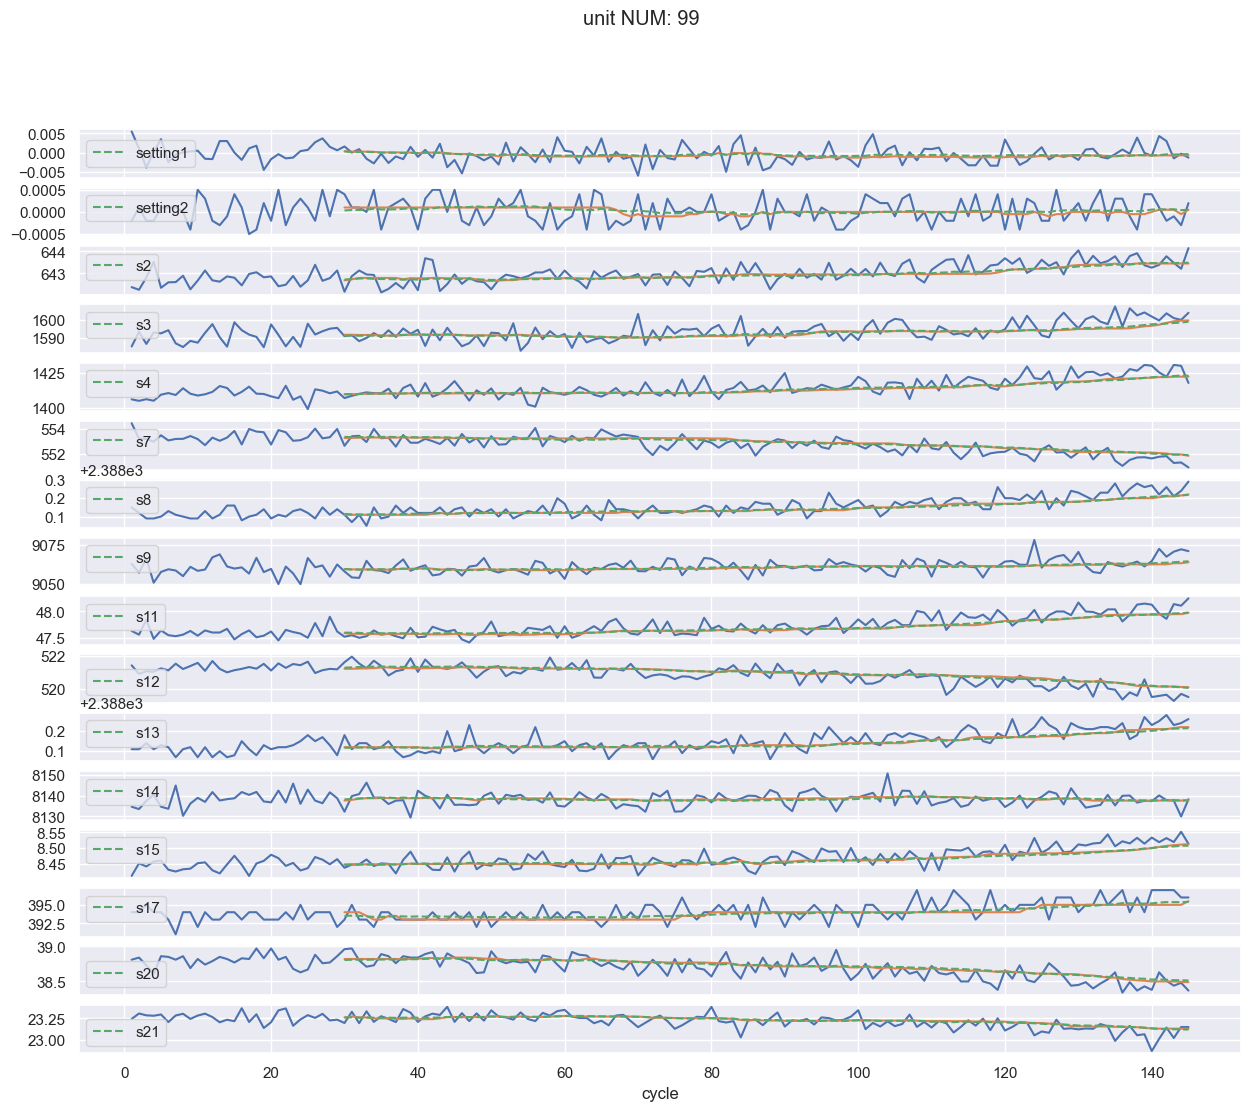

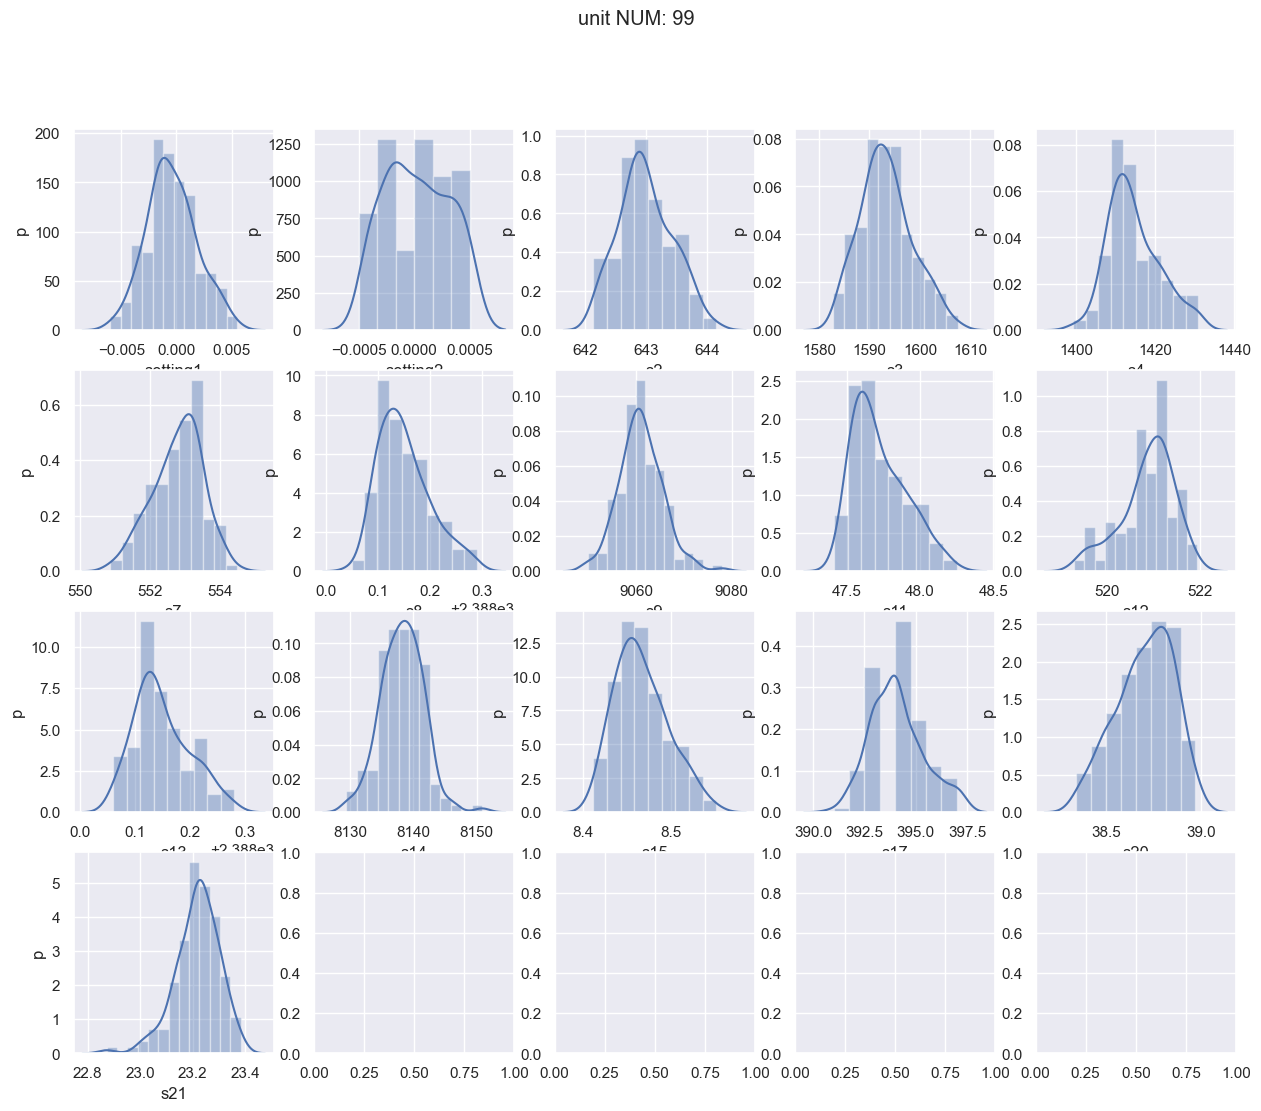

In [114]:
# Plotting sensor readings and distribution of sensor readings for machines with shortest, medium and longest operating times
warnings.filterwarnings('ignore')

# plot shortest operating time machine data
unit_to_plt = mapp_len[0][0]
plot_ts(train_df, unit_to_plt, wind_size)
plot_hist(train_df, unit_to_plt, wind_size)

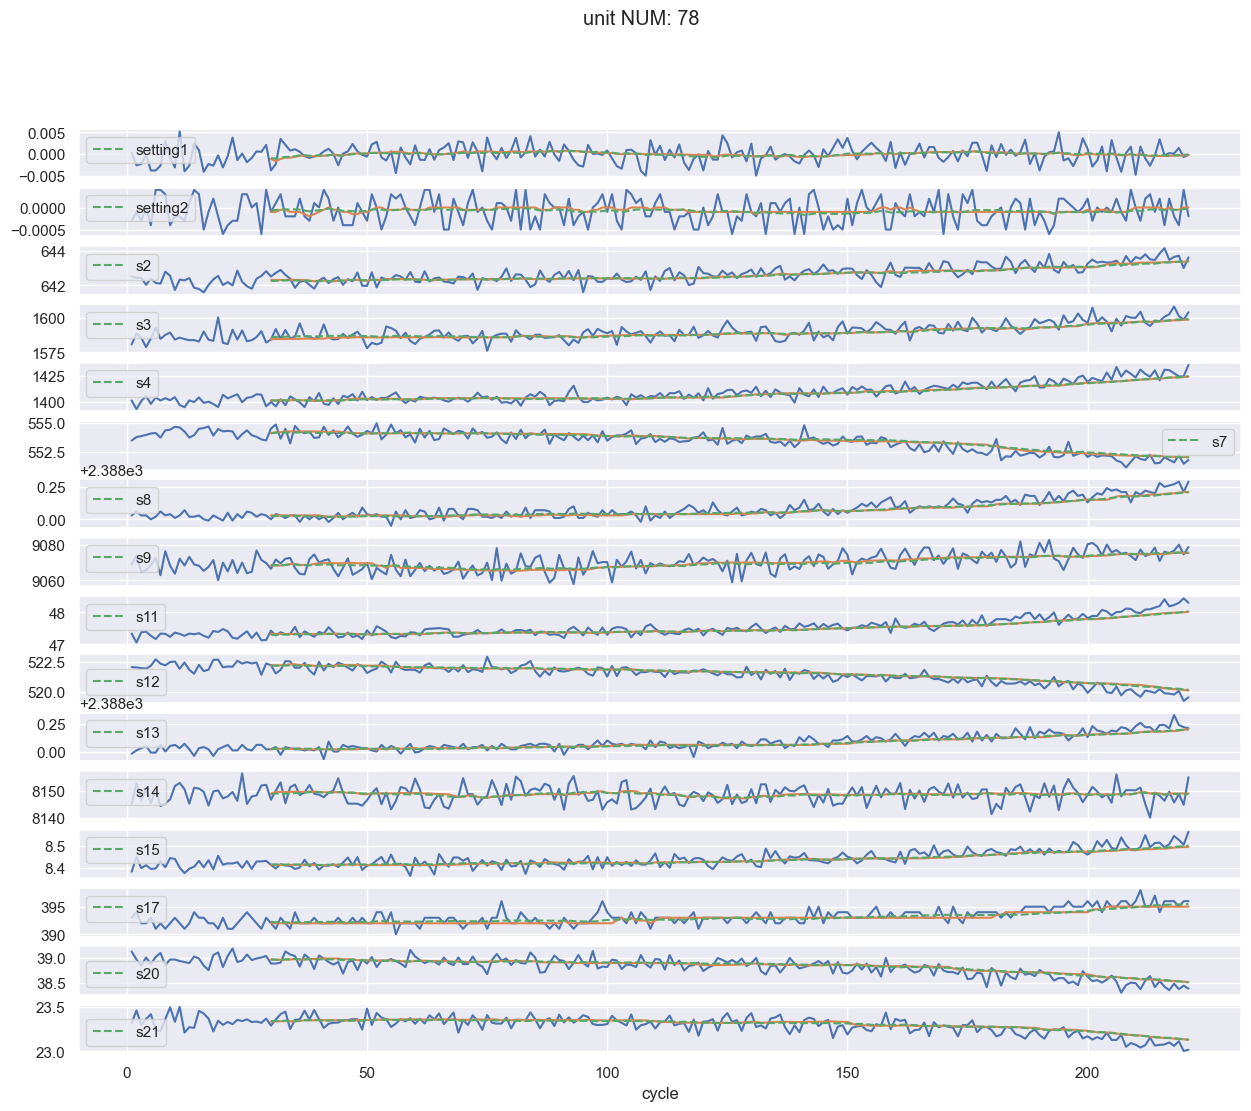

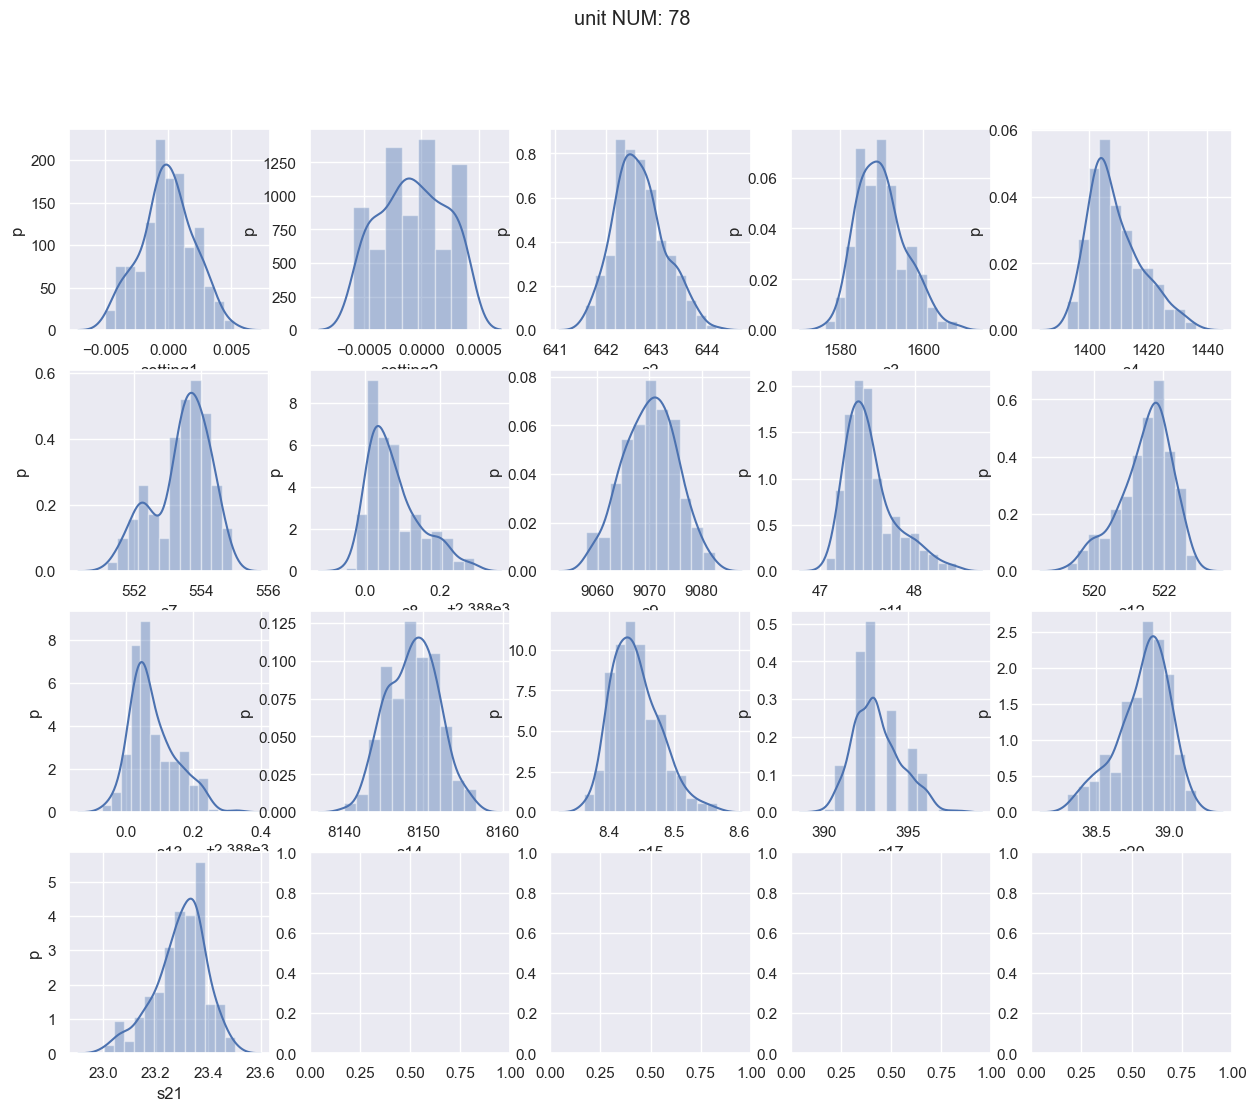

In [115]:
# plot medium operating time machine data
unit_to_plt = mapp_len[int(len(mapp)/2)][0]
plot_ts(train_df, unit_to_plt, wind_size)
plot_hist(train_df, unit_to_plt, wind_size)

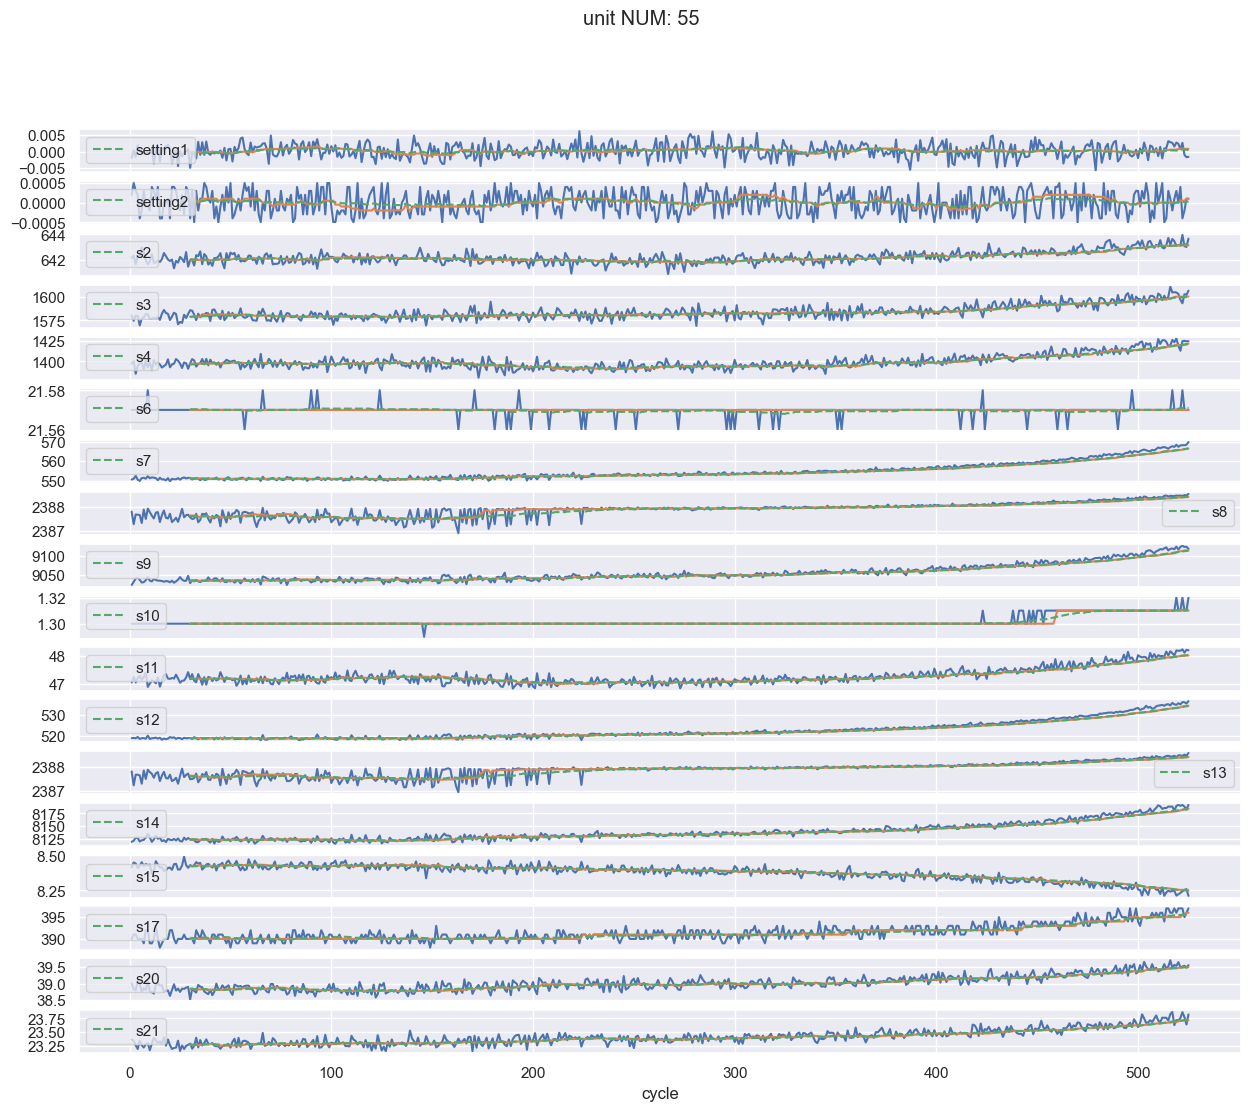

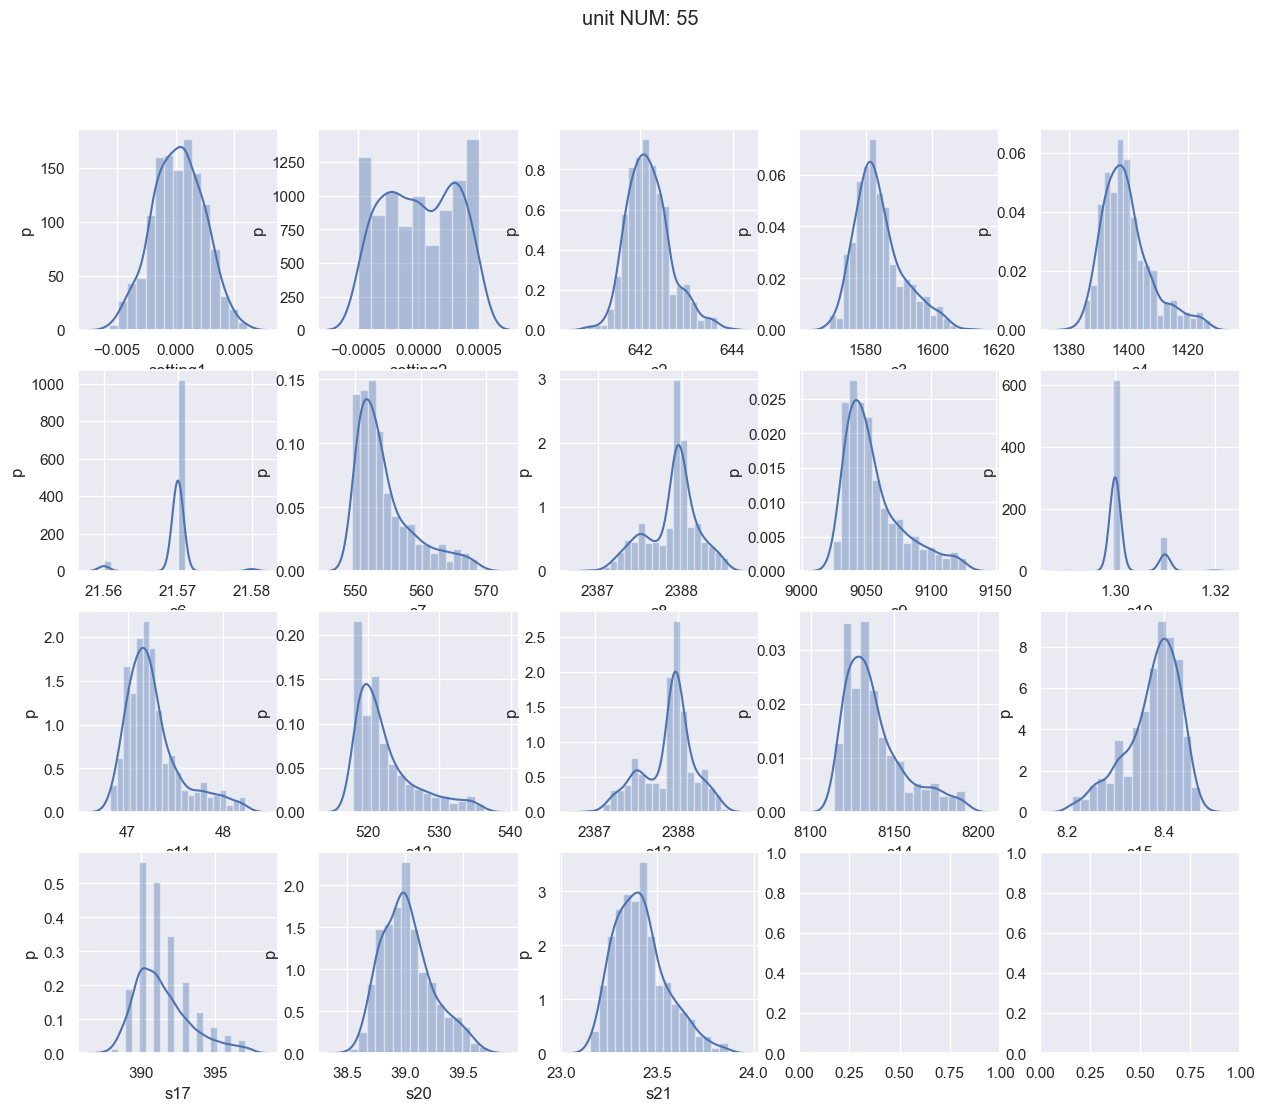

In [116]:
# plot longest operating time machine data
unit_to_plt = mapp_len[-1][0]
plot_ts(train_df, unit_to_plt, wind_size)
plot_hist(train_df, unit_to_plt, wind_size)

warnings.filterwarnings('default')

## Data Preprocessing


### Data Labeling

Generating labels for the training data for both prediction tasks:
- Remaining Useful Life ("RUL") for regression task
- "label1" for binary classification (to answer the question: is a specific engine going to fail within "w1" cycles?)

Columns "RUL" and "label1" are created

(*Note*: Column names are case-sensitive and this section is already coded.)

In [117]:
# Data Labeling for training data - generate column RUL

rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# generate label1 column for training data
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df.head(10)


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1
0,1,1,-0.0005,0.0004,100.0,518.67,642.36,1583.23,1396.84,14.62,...,8145.32,8.4246,0.03,391,2388,100.0,39.11,23.3537,258,0
1,1,2,0.0008,-0.0003,100.0,518.67,642.50,1584.69,1396.89,14.62,...,8152.85,8.4403,0.03,392,2388,100.0,38.99,23.4491,257,0
2,1,3,-0.0014,-0.0002,100.0,518.67,642.18,1582.35,1405.61,14.62,...,8150.17,8.3901,0.03,391,2388,100.0,38.85,23.3669,256,0
3,1,4,-0.0020,0.0001,100.0,518.67,642.92,1585.61,1392.27,14.62,...,8146.56,8.3878,0.03,392,2388,100.0,38.96,23.2951,255,0
4,1,5,0.0016,0.0000,100.0,518.67,641.68,1588.63,1397.65,14.62,...,8147.80,8.3869,0.03,392,2388,100.0,39.14,23.4583,254,0
5,1,6,0.0011,-0.0005,100.0,518.67,642.24,1584.09,1400.01,14.62,...,8144.92,8.4152,0.03,393,2388,100.0,38.92,23.4281,253,0
6,1,7,-0.0038,0.0002,100.0,518.67,642.58,1585.61,1401.09,14.62,...,8147.05,8.3842,0.03,391,2388,100.0,38.84,23.4087,252,0
7,1,8,-0.0007,-0.0005,100.0,518.67,642.32,1588.32,1397.08,14.62,...,8157.34,8.4190,0.03,391,2388,100.0,39.05,23.4590,251,0
8,1,9,-0.0026,0.0000,100.0,518.67,641.64,1587.81,1406.51,14.62,...,8147.20,8.4091,0.03,392,2388,100.0,38.99,23.4693,250,0
9,1,10,0.0019,-0.0002,100.0,518.67,642.42,1587.39,1402.25,14.62,...,8152.86,8.3987,0.03,391,2388,100.0,38.94,23.4781,249,0


In [118]:
# Data Labeling for test data - generate column RUL

rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

# generate label1 column for test data
test_df['label1'] = np.where(test_df['RUL'] <= w1, 1, 0 )
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label1
0,1,1,-0.0017,-0.0004,100.0,518.67,641.94,1581.93,1396.93,14.62,...,8133.48,8.3760,0.03,391,2388,100.0,39.07,23.4468,276,0
1,1,2,0.0006,-0.0002,100.0,518.67,642.02,1584.86,1398.90,14.62,...,8137.44,8.4062,0.03,391,2388,100.0,39.04,23.4807,275,0
2,1,3,0.0014,-0.0003,100.0,518.67,641.68,1581.78,1391.92,14.62,...,8138.25,8.3553,0.03,391,2388,100.0,39.10,23.4244,274,0
3,1,4,0.0027,0.0001,100.0,518.67,642.20,1584.53,1395.34,14.62,...,8137.07,8.3709,0.03,392,2388,100.0,38.97,23.4782,273,0
4,1,5,-0.0001,0.0001,100.0,518.67,642.46,1589.03,1395.86,14.62,...,8134.20,8.4146,0.03,391,2388,100.0,39.09,23.3950,272,0


### Data Normalization

Perform minmax normalization using MinMax scaler in sklearn on both training and test data (train_df and test_df)


In [119]:
# MinMax normalization for training data

train_df['cycle_norm'] = train_df['cycle']
columns_to_normalize = train_df.columns.difference(['id', 'cycle', 'RUL', 'label1'])
# [WriteCode]
scaler = preprocessing.MinMaxScaler()
# train_df['cycle_norm'] = scaler.fit_transform(train_df)
train_df[columns_to_normalize] = scaler.fit_transform(train_df[columns_to_normalize])
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,cycle_norm
0,1,1,0.470930,0.769231,0.0,0.0,0.355972,0.370523,0.308580,0.0,...,0.647755,0.0,0.272727,0.0,0.0,0.559524,0.446331,258,0,0.000000
1,1,2,0.546512,0.230769,0.0,0.0,0.388759,0.399100,0.309360,0.0,...,0.685659,0.0,0.363636,0.0,0.0,0.488095,0.534836,257,0,0.001908
2,1,3,0.418605,0.307692,0.0,0.0,0.313817,0.353298,0.445398,0.0,...,0.564462,0.0,0.272727,0.0,0.0,0.404762,0.458577,256,0,0.003817
3,1,4,0.383721,0.538462,0.0,0.0,0.487119,0.417107,0.237285,0.0,...,0.558909,0.0,0.363636,0.0,0.0,0.470238,0.391966,255,0,0.005725
4,1,5,0.593023,0.461538,0.0,0.0,0.196721,0.476218,0.321217,0.0,...,0.556736,0.0,0.363636,0.0,0.0,0.577381,0.543371,254,0,0.007634


In [120]:
# MinMax normalization for test data

test_df['cycle_norm'] = test_df['cycle']

# [WriteCode]
# scaler = preprocessing.MinMaxScaler()
# test_df['cycle_norm'] = scaler.transform(test_df)
test_df[columns_to_normalize] = scaler.transform(test_df[columns_to_normalize])
test_df.head()


,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,cycle_norm
0,1,1,0.401163,0.153846,0.0,0.0,0.257611,0.345077,0.309984,0.0,...,0.530420,0.0,0.272727,0.0,0.0,0.535714,0.532702,276,0,0.000000
1,1,2,0.534884,0.307692,0.0,0.0,0.276347,0.402427,0.340718,0.0,...,0.603332,0.0,0.272727,0.0,0.0,0.517857,0.564153,275,0,0.001908
2,1,3,0.581395,0.230769,0.0,0.0,0.196721,0.342141,0.231825,0.0,...,0.480444,0.0,0.272727,0.0,0.0,0.553571,0.511921,274,0,0.003817
3,1,4,0.656977,0.538462,0.0,0.0,0.318501,0.395968,0.285179,0.0,...,0.518107,0.0,0.363636,0.0,0.0,0.476190,0.561833,273,0,0.005725
4,1,5,0.494186,0.538462,0.0,0.0,0.379391,0.484048,0.293292,0.0,...,0.623612,0.0,0.272727,0.0,0.0,0.547619,0.484646,272,0,0.007634


### Data Plotting

In this section, students must plot training data. Please do the follwing:
- Use only data pertaining to engine id = 3
- Plot only the last "sequence_length" operating cycles for each sensor reading in engine 3 training data (for example: if seq_len = 50, plot the last 50 operating cycles of engine 3). 
- Use separate plot for each column or sensor reading. 

X axis: cycles and Y axis : sensor reading

expected result:
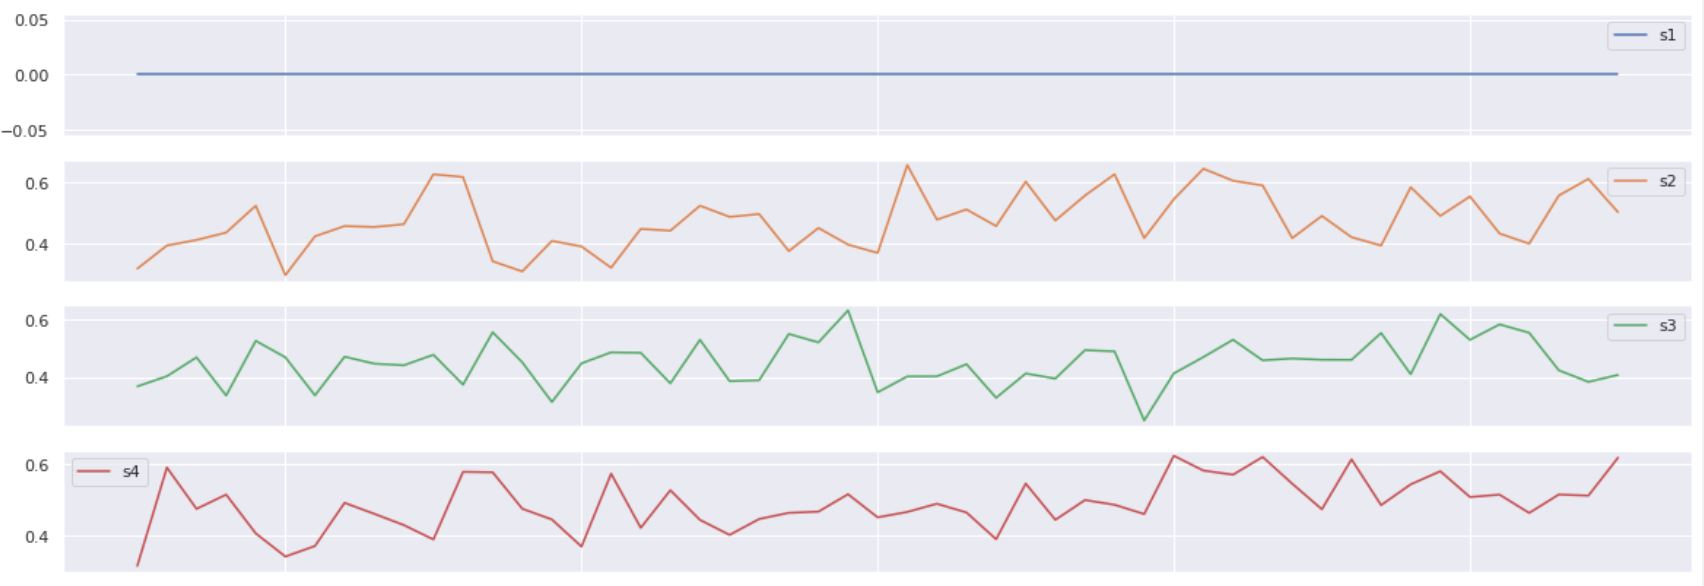

d:\anaconda3\envs\EEC4400\lib\site-packages\pandas\plotting\_matplotlib\compat.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  op(LooseVersion(mpl.__version__), LooseVersion(version))
d:\anaconda3\envs\EEC4400\lib\site-packages\pandas\plotting\_matplotlib\compat.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  op(LooseVersion(mpl.__version__), LooseVersion(version))
d:\anaconda3\envs\EEC4400\lib\site-packages\pandas\plotting\_matplotlib\compat.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  op(LooseVersion(mpl.__version__), LooseVersion(version))
d:\anaconda3\envs\EEC4400\lib\site-packages\pandas\plotting\_matplotlib\compat.py:13: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  op(LooseVersion(mpl.__version__), LooseVersion(version))
d:\anaconda3\envs\EEC4400\lib\site-packages\pand

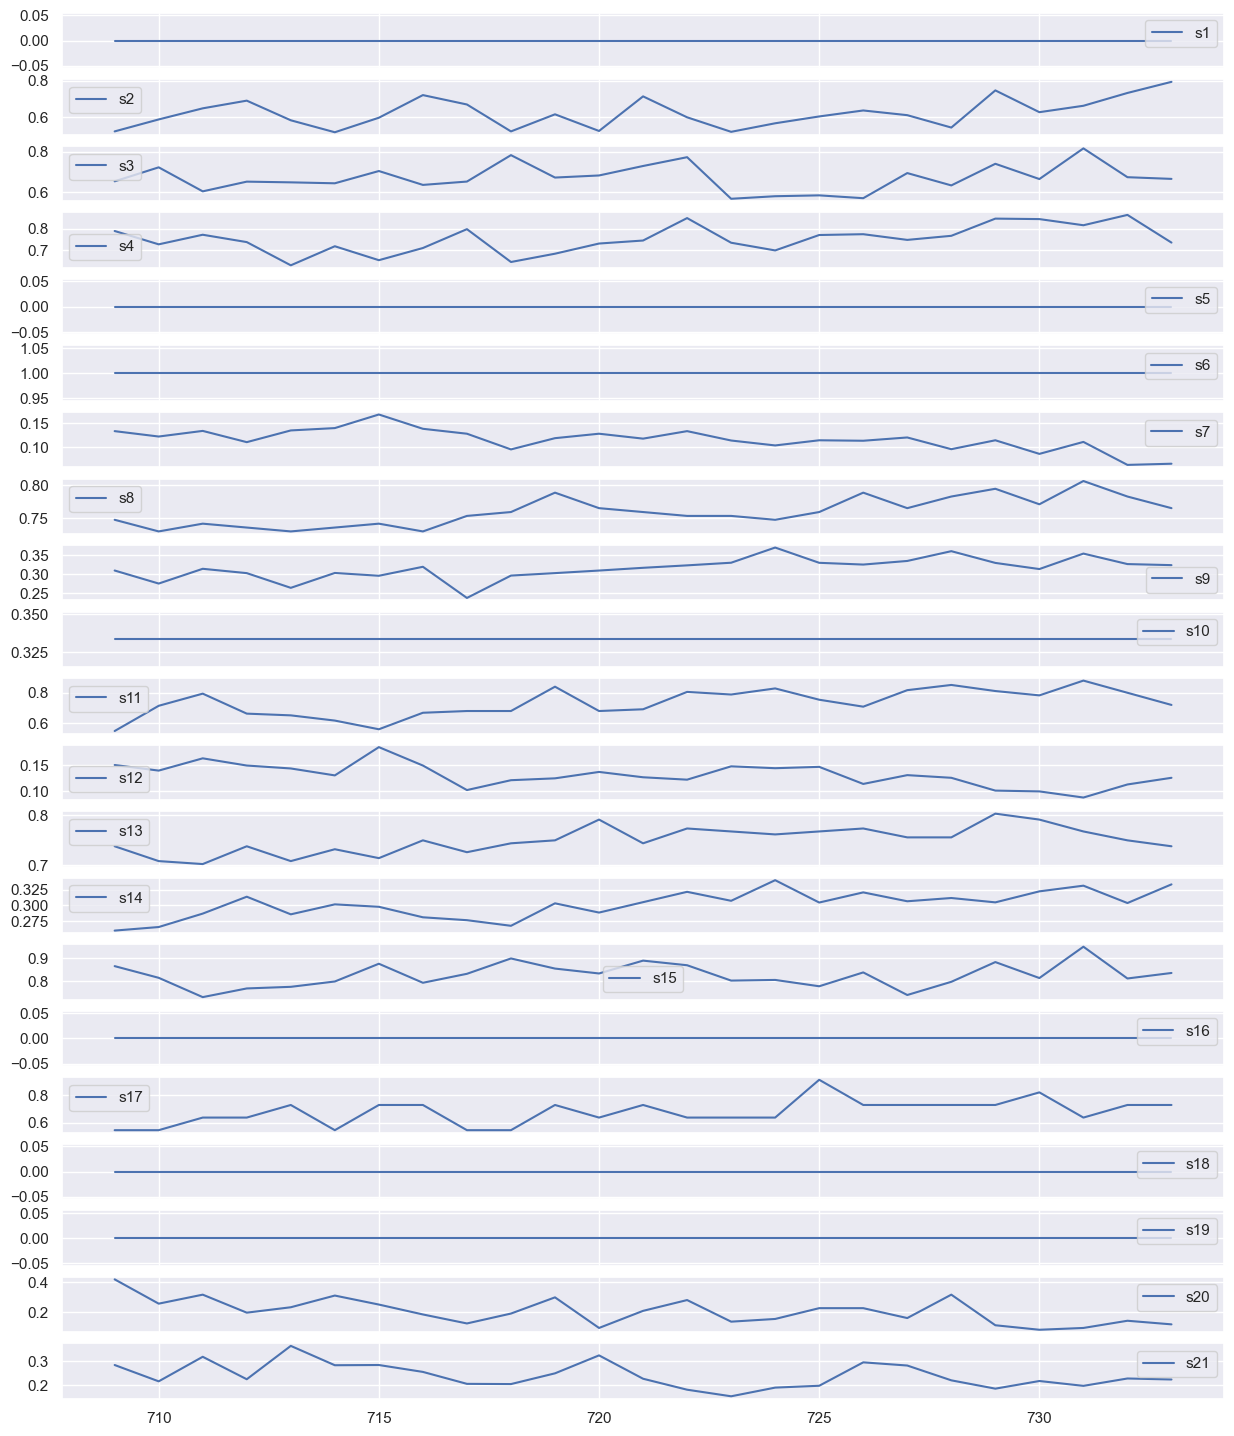

In [121]:
# [WriteCode]
draw_df = train_df[train_df['id'] == 3]
draw_df = draw_df[-sequence_length:]
cycle = draw_df['cycle']
draw_df = draw_df.drop(columns=['id', 'cycle', 'setting1', 'setting2', 'setting3', 'RUL', 'label1', 'cycle_norm'])
fig, axes = plt.subplots(21, 1, figsize=(15,18))
draw_df.head()
for col, ax in zip(draw_df.columns, axes):
    draw_df[col].plot(ax = ax, legend=True)
    # plt.legend()
    # df_sub[col].rolling(wind_size).median().plot(ax = ax)
    # df_sub[col].rolling(wind_size).mean().plot(style = '--', legend=True, ax = ax)




### Data Sequence Generation

Any deep learning model requires two data arrays for model training. The first array is the input sequence array X (named "**seq_array**" in this skeleton file) which contains the input features. The second array is the desired target array Y (named "**label_array**" in this skeleton file) which contains the actual output or ground truth. This target output "label_array" is different for binary classification and RUL regression.

In addition, Keras layers expect the input "seq_array" in the shape of a numpy array of 3 dimensions (no. of samples, time steps, features) where no. of samples is the number of training sequences, time steps is the look back window of sequence length and features is the number of features of each sequence at each time step. 

In this section, train_df is used to generate seq_array. Label_array generation is done separately for each prediction task.

In [122]:
# function to reshape features into seq_array: (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means
    we need to drop those which are below the window-length. """
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]

# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# generator for the training sequences
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)

# final seq_array which is X input to CNN/LSTM
print(seq_array.shape)

(22220, 25, 25)


## Failure Classification

### Label array generation


In [123]:
# function to generate label_array
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

# generate labels (generated from "label1" col as its binary classification)
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label1']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

# final label_array which is Y target output for CNN and LSTM 
print(label_array.shape)

(22220, 1)


### CNN Model
In this section, build a 1D CNN network to do binary classification. The choice of network architecture - no. of layers, type of layers (1D CNN, maxpooling etc.), nodes per layer, activations - is left to students. Please include the following:
- name the model as "model_cnn_bin"
- dropout layer after each CNN layer (drop probability of your choice)
- output dense layer with appropriate no. of nodes and activation for binary classification
- appropriate loss function and optimizer.

Set 'accuracy' as the metric.

Print the model summary.


In [124]:
# [WriteCode]
# Define the 1D CNN model
model_cnn_bin = Sequential()

# Add Conv1D layers with Dropout
model_cnn_bin.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, len(sequence_cols))))
model_cnn_bin.add(MaxPooling1D(pool_size=2))
model_cnn_bin.add(Dropout(0.3))

model_cnn_bin.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn_bin.add(MaxPooling1D(pool_size=2))
model_cnn_bin.add(Dropout(0.3))

model_cnn_bin.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn_bin.add(MaxPooling1D(pool_size=2))
model_cnn_bin.add(Dropout(0.3))

# Flatten the output and add dense layers
model_cnn_bin.add(Flatten())
model_cnn_bin.add(Dense(64, activation='relu'))
model_cnn_bin.add(Dropout(0.3))
model_cnn_bin.add(Dense(32, activation='relu'))
model_cnn_bin.add(Dropout(0.3))

# Output layer for binary classification
model_cnn_bin.add(Dense(1, activation='sigmoid'))

# Compile the model
model_cnn_bin.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Print the model summary
model_cnn_bin.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 23, 32)            2432      
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 11, 32)            0         
_________________________________________________________________
dropout_70 (Dropout)         (None, 11, 32)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 9, 64)             6208      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 2, 128)          

#### Model Training

Fit the model using **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_bin") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_bin" for visualization.

In [125]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_cnn_bin"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]
# Set the callback for TensorBoard
cb = keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_bin"),
                                  histogram_freq=1,
                                  write_graph=True,
                                  update_freq='epoch')

# Train the model
history = model_cnn_bin.fit(seq_array,
                             label_array,
                             epochs=ep,
                             batch_size=ba,
                             validation_split=0.05,
                             callbacks=[cb])

# Display the training history
print(history.history.keys())

Epoch 1/5
212/212 [==============================] - 2s 6ms/step - loss: 0.2215 - accuracy: 0.9128 - val_loss: 0.0989 - val_accuracy: 0.9568
Epoch 2/5
212/212 [==============================] - 1s 5ms/step - loss: 0.1150 - accuracy: 0.9560 - val_loss: 0.0827 - val_accuracy: 0.9829
Epoch 3/5
212/212 [==============================] - 1s 7ms/step - loss: 0.1037 - accuracy: 0.9589 - val_loss: 0.0657 - val_accuracy: 0.9703
Epoch 4/5
212/212 [==============================] - 1s 5ms/step - loss: 0.1020 - accuracy: 0.9582 - val_loss: 0.0665 - val_accuracy: 0.9775
Epoch 5/5
212/212 [==============================] - 1s 5ms/step - loss: 0.0964 - accuracy: 0.9619 - val_loss: 0.0851 - val_accuracy: 0.9730
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
CPU times: total: 19 s
Wall time: 6.53 s


#### Training data performance metrics

- Determine the accuracy of prediction of the trained model on the training data
- Print the confusion matrix for training data prediction
- Print the precision and recall for training data prediction

Training Accuracy: 0.9638
Confusion Matrix:
 [[19011   109]
 [  696  2404]]
Precision: 0.9566
Recall: 0.7755


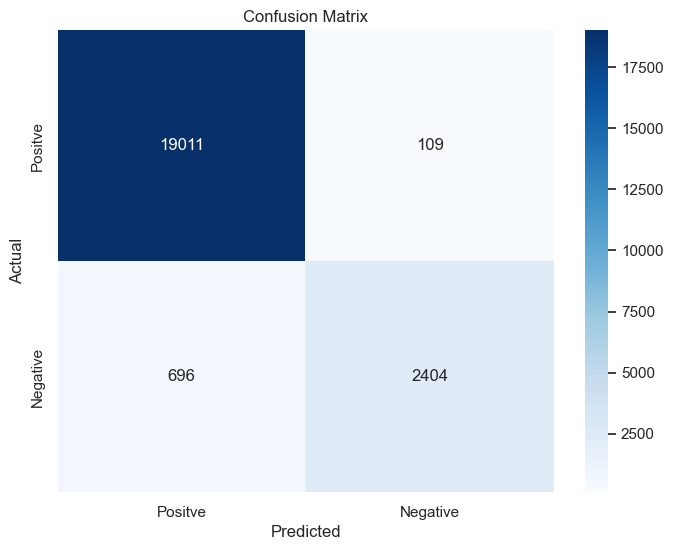

In [126]:
# [WriteCode]
# Make predictions on the training data
train_predictions = (model_cnn_bin.predict(seq_array) > 0.5).astype(int)

# Calculate accuracy
accuracy = (train_predictions == label_array).mean()
print(f"Training Accuracy: {accuracy:.4f}")

# Generate confusion matrix
cm = confusion_matrix(label_array, train_predictions)
print("Confusion Matrix:\n", cm)

# Calculate precision and recall
precision = precision_score(label_array, train_predictions)
recall = recall_score(label_array, train_predictions)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Optional: Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Positve", "Negative"], yticklabels=["Positve", "Negative"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [127]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

(100, 25, 25)
(100, 1)


#### Test data performance metrics

- Determine the accuracy of prediction of the trained model on the test data
- Print the confusion matrix for test data prediction
- Print the precision, recall and F1 score for test data prediction

*Note*: use seq_array_test_last and label_array_test_last generated in the cell above as X and Y arrays (in place of seq_array and label_array) for performing prediction and calculating metrics

Test Accuracy: 0.7040
Confusion Matrix (Test Data):
 [[79  1]
 [ 5 15]]
Precision (Test Data): 0.9375
Recall (Test Data): 0.7500
F1 Score (Test Data): 0.8333


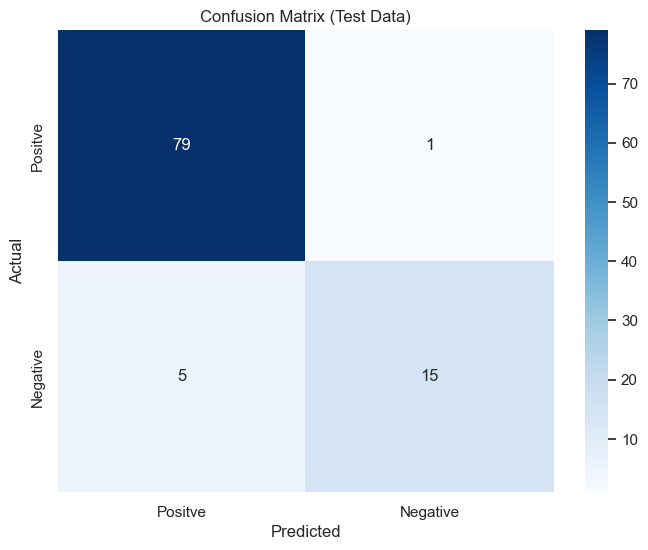

In [128]:
# [WriteCode]
# Make predictions on the test data
test_predictions = (model_cnn_bin.predict(seq_array_test_last) > 0.5).astype(int)

# Calculate accuracy
test_accuracy = (test_predictions.flatten() == label_array_test_last).mean()
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate confusion matrix
cm_test = confusion_matrix(label_array_test_last, test_predictions)
print("Confusion Matrix (Test Data):\n", cm_test)

# Calculate precision, recall, and F1 score
test_precision = precision_score(label_array_test_last, test_predictions)
test_recall = recall_score(label_array_test_last, test_predictions)
test_f1 = f1_score(label_array_test_last, test_predictions)

print(f"Precision (Test Data): {test_precision:.4f}")
print(f"Recall (Test Data): {test_recall:.4f}")
print(f"F1 Score (Test Data): {test_f1:.4f}")

# Optional: Plot confusion matrix using seaborn for test data
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=["Positve", "Negative"], yticklabels=["Positve", "Negative"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Test Data)')
plt.show()

#### Hyperparameter Optimisation

This involves finding the best network architecture (no. and types of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the CNN model for binary classification. 

Since a systematic search is highly computationally expensive, you will only design and implement an improved CNN model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline CNN model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved CNN model (named "model_cnn_bin_alt").
- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_bin_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_bin_alt" for visualization.
- Evaluate and print training data accuracy, confusion matrix, precision and recall.
- Evaluate and print test data accuracy, confusion matrix, precision, recall and F1 score (use seq_array_test_last and label_array_test_last generated previously).

In [129]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_cnn_bin_alt"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]

CPU times: total: 0 ns
Wall time: 1 ms


### LSTM Network
In this section build a LSTM network to do binary classification. The choice of network architecture - no. of layers, type of layers, nodes per layer, activations - is left to students. Please include the following:
- name the model as "model_lstm_bin"
- dropout layer after each LSTM layer (drop probability of your choice)
- output dense layer with appropriate no. of nodes and activation for binary classification
- appropriate loss function and optimizer.

Set 'accuracy' as the metric.

Print the model summary.



In [130]:
# [WriteCode]
model_lstm_bin = Sequential()
model_lstm_bin.add(LSTM(50, return_sequences=True, input_shape=(seq_array.shape[1], seq_array.shape[2])))
model_lstm_bin.add(Dropout(0.2))
model_lstm_bin.add(LSTM(50))
model_lstm_bin.add(Dropout(0.2))
model_lstm_bin.add(Dense(1, activation='sigmoid'))


model_lstm_bin.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_bin.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 25, 50)            15200     
_________________________________________________________________
dropout_75 (Dropout)         (None, 25, 50)            0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_76 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 51        
Total params: 35,451
Trainable params: 35,451
Non-trainable params: 0
_________________________________________________________________


#### Model Training

Fit the model on **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_bin") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_bin" for visualization.

Epoch 1/5
212/212 [==============================] - 9s 30ms/step - loss: 0.1997 - accuracy: 0.9265 - val_loss: 0.0706 - val_accuracy: 0.9703
Epoch 2/5
212/212 [==============================] - 6s 28ms/step - loss: 0.0911 - accuracy: 0.9635 - val_loss: 0.0834 - val_accuracy: 0.9748
Epoch 3/5
212/212 [==============================] - 6s 27ms/step - loss: 0.0848 - accuracy: 0.9657 - val_loss: 0.0549 - val_accuracy: 0.9775
Epoch 4/5
212/212 [==============================] - 6s 29ms/step - loss: 0.0704 - accuracy: 0.9704 - val_loss: 0.0380 - val_accuracy: 0.9874
Epoch 5/5
212/212 [==============================] - 6s 27ms/step - loss: 0.0692 - accuracy: 0.9716 - val_loss: 0.0439 - val_accuracy: 0.9847


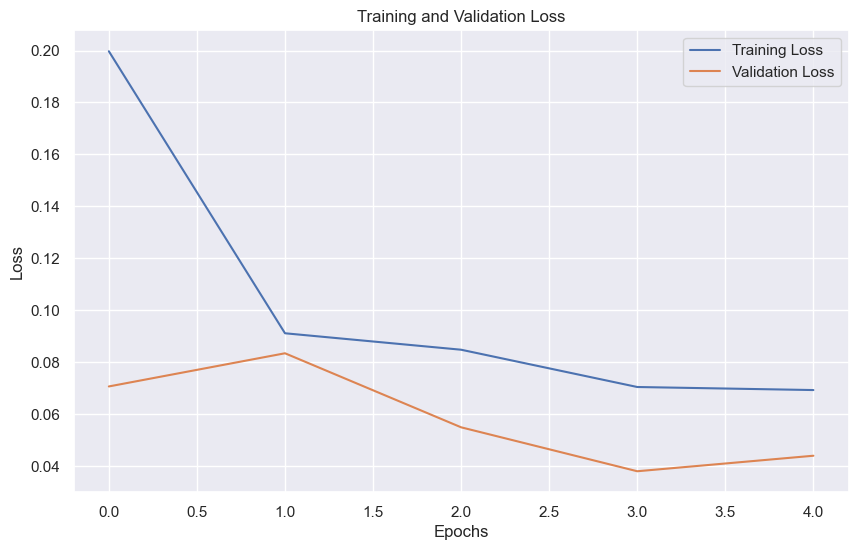

CPU times: total: 1min 42s
Wall time: 33 s


In [131]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_lstm_bin"), histogram_freq=1, write_graph= True, update_freq='epoch')
# [WriteCode]

history = model_lstm_bin.fit(seq_array, label_array, epochs=ep, batch_size=ba, validation_split=0.05, callbacks=[cb])

# 绘制训练集和验证集的损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#### Training data performance metrics

- Determine the accuracy of prediction of the trained model on the training data
- Print the confusion matrix for training data prediction
- Print the precision and recall for training data prediction

Training accuracy: 0.9774977497749775
Training precision: 0.9059962523422861
Training recall: 0.9358064516129032
Training F1 score: 0.9206601079022533
Confusion matrix:
 [[18819   301]
 [  199  2901]]


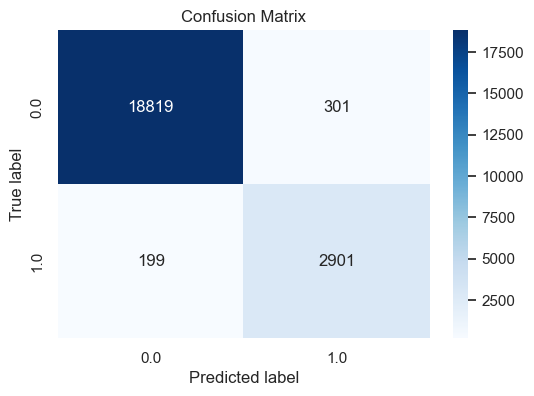

In [132]:
# [WriteCode]
y_pred = model_lstm_bin.predict(seq_array)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
accuracy = accuracy_score(label_array, y_pred_binary)
precision = precision_score(label_array, y_pred_binary)
recall = recall_score(label_array, y_pred_binary)
f1 = f1_score(label_array, y_pred_binary)


print("Training accuracy:", accuracy)
print("Training precision:", precision)
print("Training recall:", recall)
print("Training F1 score:", f1)
confusion_mat = confusion_matrix(label_array, y_pred_binary)
print("Confusion matrix:\n", confusion_mat)
df_cm = pd.DataFrame(confusion_mat, index=[i for i in np.unique(label_array)], columns=[i for i in np.unique(label_array)])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [133]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['label1'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

(100, 25, 25)
(100, 1)


#### Test data performance metrics

- Determine the accuracy of prediction of the trained model on the test data
- Print the confusion matrix for test data prediction
- Print the precision, recall and F1 score for test data prediction

*Note*: use seq_array_test_last and label_array_test_last generated in the cell above as X and Y arrays (in place of seq_array and label_array) for performing prediction and calculating metrics

Testing accuracy: 0.97
Testing precision: 0.9473684210526315
Testing recall: 0.9
Testing F1 score: 0.9230769230769231
Confusion matrix:
 [[79  1]
 [ 2 18]]


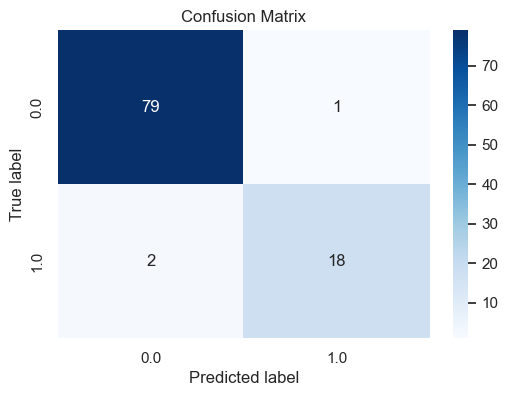

In [134]:
# [WriteCode]
y_pred = model_lstm_bin.predict(seq_array_test_last)
y_pred_binary = (y_pred > 0.5).astype(int)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
accuracy = accuracy_score(label_array_test_last, y_pred_binary)
precision = precision_score(label_array_test_last, y_pred_binary)
recall = recall_score(label_array_test_last, y_pred_binary)
f1 = f1_score(label_array_test_last, y_pred_binary)

print("Testing accuracy:", accuracy)
print("Testing precision:", precision)
print("Testing recall:", recall)
print("Testing F1 score:", f1)
confusion_mat = confusion_matrix(label_array_test_last, y_pred_binary)
print("Confusion matrix:\n", confusion_mat)
df_cm = pd.DataFrame(confusion_mat, index=[i for i in np.unique(label_array_test_last)], columns=[i for i in np.unique(label_array)])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

#### Hyperparameter Optimisation

This involves finding the best network architecture (no. and types of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the LSTM model for binary classification. 

Since a systematic search is highly computationally expensive, you will only design and implement an improved LSTM model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline LSTM model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved LSTM model (named "model_lstm_bin_alt").

- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_bin_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_bin_alt" for visualization.
- Evaluate and print training data accuracy, confusion matrix, precision and recall.
- Evaluate and print test data accuracy, confusion matrix, precision, recall and F1 score (use seq_array_test_last and label_array_test_last generated previously).

In [135]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_lstm_bin_alt"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]
model_lstm_bin_alt = Sequential()
model_lstm_bin_alt.add(LSTM(50, return_sequences=True, input_shape=(seq_array.shape[1], seq_array.shape[2])))
model_lstm_bin_alt.add(Dropout(0.25))
model_lstm_bin_alt.add(LSTM(50))
model_lstm_bin_alt.add(Dropout(0.25))
model_lstm_bin_alt.add(Dense(1, activation='sigmoid'))


model_lstm_bin_alt.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model_lstm_bin_alt.summary()


early_stopping = EarlyStopping(monitor='val_loss',  
                   patience=5, 
                   verbose=True)
history = model_lstm_bin_alt.fit(seq_array, label_array, epochs=100, batch_size=ba, validation_split=0.05, callbacks=[early_stopping, cb])

# 绘制训练集和验证集的损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

y_pred = model_lstm_bin_alt.predict(seq_array)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(label_array, y_pred_binary)
precision = precision_score(label_array, y_pred_binary)
recall = recall_score(label_array, y_pred_binary)
f1 = f1_score(label_array, y_pred_binary)


print("Training accuracy:", accuracy)
print("Training precision:", precision)
print("Training recall:", recall)
print("Training F1 score:", f1)
confusion_mat = confusion_matrix(label_array, y_pred_binary)
print("Training Confusion matrix:\n", confusion_mat)
df_cm = pd.DataFrame(confusion_mat, index=[i for i in np.unique(label_array)], columns=[i for i in np.unique(label_array)])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Training Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

y_pred = model_lstm_bin_alt.predict(seq_array_test_last)
y_pred_binary = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(label_array_test_last, y_pred_binary)
precision = precision_score(label_array_test_last, y_pred_binary)
recall = recall_score(label_array_test_last, y_pred_binary)
f1 = f1_score(label_array_test_last, y_pred_binary)

print("Testing accuracy:", accuracy)
print("Testing precision:", precision)
print("Testing recall:", recall)
print("Testing F1 score:", f1)
confusion_mat = confusion_matrix(label_array_test_last, y_pred_binary)
print("Testing Confusion matrix:\n", confusion_mat)
df_cm = pd.DataFrame(confusion_mat, index=[i for i in np.unique(label_array_test_last)], columns=[i for i in np.unique(label_array)])
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Testing Confusion Matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 25, 50)            15200     
_________________________________________________________________
dropout_77 (Dropout)         (None, 25, 50)            0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_78 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 51        
Total params: 35,451
Trainable params: 35,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
  2/212 [..............................] - ETA: 22s - loss: 0.6162 - accuracy: 0.8300 

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb4 in position 147: invalid start byte

### Comparing CNN 1D and LSTM models for binary classification

Using a Pandas dataframe, combine the results obtained for binary classification such as accuracy, precision, recall and F1 score for test data of the CNN, LSTM, alt-CNN and alt-LSTM models for binary classification.

Display this dataframe.

In [136]:
# [WriteCode]
# CNN_bin
y_pred_cnn_bin = model_cnn_bin.predict(seq_array_test_last)
y_pred_binary_cnn_bin = (y_pred_cnn_bin > 0.5).astype(int)

accuracy_cnn_bin = accuracy_score(label_array_test_last, y_pred_binary_cnn_bin)
precision_cnn_bin = precision_score(label_array_test_last, y_pred_binary_cnn_bin)
recall_cnn_bin = recall_score(label_array_test_last, y_pred_binary_cnn_bin)
f1_cnn_bin = f1_score(label_array_test_last, y_pred_binary_cnn_bin)

# LSTM_bin
y_pred_lstm_bin = model_lstm_bin.predict(seq_array_test_last)
y_pred_binary_lstm_bin = (y_pred_lstm_bin > 0.5).astype(int)

accuracy_lstm_bin = accuracy_score(label_array_test_last, y_pred_binary_lstm_bin)
precision_lstm_bin = precision_score(label_array_test_last, y_pred_binary_lstm_bin)
recall_lstm_bin = recall_score(label_array_test_last, y_pred_binary_lstm_bin)
f1_lstm_bin = f1_score(label_array_test_last, y_pred_binary_lstm_bin)

# CNN_bin_alt
'''y_pred_cnn_bin_alt = model_cnn_bin_alt.predict(seq_array_test_last)
y_pred_binary_cnn_bin_alt = (y_pred_cnn_bin_alt > 0.5).astype(int)

accuracy_cnn_bin_alt = accuracy_score(label_array_test_last, y_pred_binary_cnn_bin_alt)
precision_cnn_bin_alt = precision_score(label_array_test_last, y_pred_binary_cnn_bin_alt)
recall_cnn_bin_alt = recall_score(label_array_test_last, y_pred_binary_cnn_bin_alt)
f1_cnn_bin_alt = f1_score(label_array_test_last, y_pred_binary_cnn_bin_alt)'''
accuracy_cnn_bin_alt = 0
precision_cnn_bin_alt = 0
recall_cnn_bin_alt = 0
f1_cnn_bin_alt = 0

# LSTM_bin_alt
y_pred_lstm_bin_alt = model_lstm_bin_alt.predict(seq_array_test_last)
y_pred_binary_lstm_bin_alt = (y_pred_lstm_bin_alt > 0.5).astype(int)

accuracy_lstm_bin_alt = accuracy_score(label_array_test_last, y_pred_binary_lstm_bin_alt)
precision_lstm_bin_alt = precision_score(label_array_test_last, y_pred_binary_lstm_bin_alt)
recall_lstm_bin_alt = recall_score(label_array_test_last, y_pred_binary_lstm_bin_alt)
f1_lstm_bin_alt = f1_score(label_array_test_last, y_pred_binary_lstm_bin_alt)


data = {'Model': ['CNN', 'LSTM', 'CNN-alt', 'LSTM-alt'],
        'accuracy': [accuracy_cnn_bin, accuracy_lstm_bin, accuracy_cnn_bin_alt, accuracy_lstm_bin_alt],
        'precision': [precision_cnn_bin, precision_lstm_bin, precision_cnn_bin_alt, precision_lstm_bin_alt],
        'recall': [recall_cnn_bin, recall_lstm_bin, recall_cnn_bin_alt, recall_lstm_bin_alt],
        'f1': [f1_cnn_bin, f1_lstm_bin, f1_cnn_bin_alt, f1_lstm_bin_alt]}
df = pd.DataFrame(data)
print(df)

      Model  accuracy  precision  recall        f1
0       CNN      0.94   0.937500    0.75  0.833333
1      LSTM      0.97   0.947368    0.90  0.923077
2   CNN-alt      0.00   0.000000    0.00  0.000000
3  LSTM-alt      0.80   0.000000    0.00  0.000000


d:\anaconda3\envs\EEC4400\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## RUL Regression

### Label array generation


In [137]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

# generate labels (generated from "RUL" col as it's RUL regression)
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)

# final label_array which is Y target output to CNN/LSTM
print(label_array.shape)

(22220, 1)


### CNN Model

In this section, build a 1D CNN network to do RUL regression. Use the **same** CNN network architecture (no. and types of layers, no. of nodes per layer, activations) as the binary classification case. Please include the following:
- name the model as "model_cnn_rul"
- use the **same** parameter values as the baseline CNN network for binary classification
- output dense layer with appropriate no. of nodes and activation for RUL regression
- appropriate loss function and optimizer.

Set mean absolute error MAE as the metric.

Print the model summary.

In [138]:
# [WriteCode]
# Define the 1D CNN model for RUL regression
model_cnn_rul = Sequential()

# Add Conv1D layers with Dropout (same as the binary classification model)
model_cnn_rul.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, len(sequence_cols))))
model_cnn_rul.add(MaxPooling1D(pool_size=2))
model_cnn_rul.add(Dropout(0.3))

model_cnn_rul.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn_rul.add(MaxPooling1D(pool_size=2))
model_cnn_rul.add(Dropout(0.3))

model_cnn_rul.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn_rul.add(MaxPooling1D(pool_size=2))
model_cnn_rul.add(Dropout(0.3))

# Flatten and add dense layers (same as the binary classification model)
model_cnn_rul.add(Flatten())
model_cnn_rul.add(Dense(64, activation='relu'))
model_cnn_rul.add(Dropout(0.3))
model_cnn_rul.add(Dense(32, activation='relu'))
model_cnn_rul.add(Dropout(0.3))

# Output layer for regression
model_cnn_rul.add(Dense(1, activation='linear'))

# Compile the model
model_cnn_rul.compile(loss='mse', optimizer=Adam(), metrics=['mae'])

# Print the model summary
model_cnn_rul.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_21 (Conv1D)           (None, 23, 32)            2432      
_________________________________________________________________
max_pooling1d_21 (MaxPooling (None, 11, 32)            0         
_________________________________________________________________
dropout_79 (Dropout)         (None, 11, 32)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 9, 64)             6208      
_________________________________________________________________
max_pooling1d_22 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
dropout_80 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
conv1d_23 (Conv1D)           (None, 2, 128)          

#### Model Training

Fit the model on **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_rul") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_rul" for visualization.

In [139]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_cnn_rul"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]
# # Fit the model
history_rul = model_cnn_rul.fit(seq_array,
                                 label_array,
                                 epochs=ep,
                                 batch_size=ba,
                                 validation_split=0.05,
                                 callbacks=[cb])

# Display the training history
print(history_rul.history.keys())

Epoch 1/5
  1/212 [..............................] - ETA: 2:27 - loss: 27680.5801 - mae: 135.3542

ResourceExhaustedError: Failed to create a directory: .\eec4400_logs\run_cnn_rul\run_2024_11_11-12_37_25\train/plugins; No space left on device

#### Training data performance metrics

- Print the "mean absolute error" metric for training data prediction.

In [140]:
# [WriteCode]
from sklearn.metrics import mean_absolute_error

# Make predictions on the training data
train_predictions_rul = model_cnn_rul.predict(seq_array)

# Calculate mean absolute error for training data
mae_train = mean_absolute_error(label_array, train_predictions_rul)
print(f"Mean Absolute Error (Training Data): {mae_train:.4f}")

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
Mean Absolute Error (Training Data): 126.8752


#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [141]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

(100, 25, 25)
(100, 1)


#### Test data performance metrics
- print the "mean absolute error" metric for test data prediction

*Note*: use seq_array_test_last and label_array_test_last generated in the cell above as X and Y arrays (in place of seq_array and label_array) for performing prediction and calculating metrics

Mean Absolute Error on Test Data: 74.9086


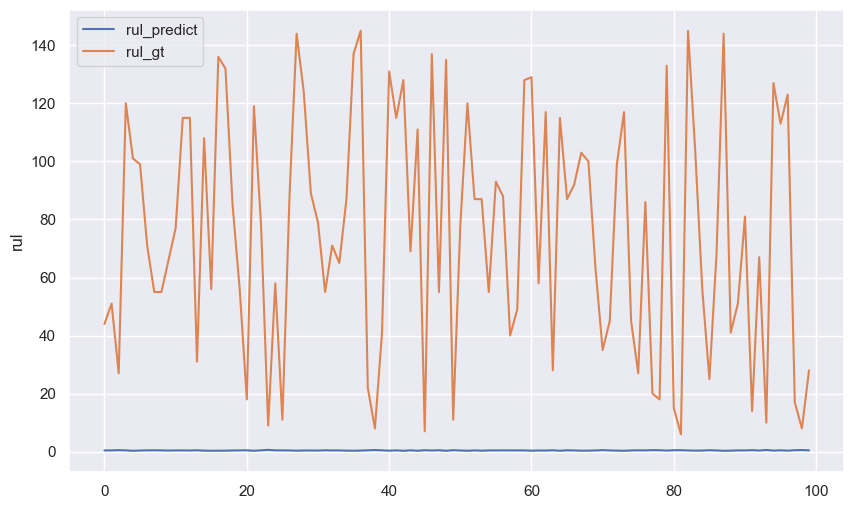

In [142]:
# [WriteCode]
# Make predictions on the test data
test_predictions = model_cnn_rul.predict(seq_array_test_last)

# Calculate mean absolute error (MAE) on the test data
mae_test = np.mean(np.abs(test_predictions - label_array_test_last))

# Print the MAE
print(f"Mean Absolute Error on Test Data: {mae_test:.4f}")
rul = model_cnn_rul.predict(seq_array_test_last)
plt.figure(figsize=(10, 6))
plt.plot(rul, label='rul_predict')
plt.plot(label_array_test_last, label='rul_gt')
plt.ylabel('rul')
plt.legend()
plt.show()

#### Hyperparameter Optimisation

This involves finding the best network architecture (no. of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the CNN model for RUL regression.

Since a systematic search is highly computationally expensive, you will only design and implement an improved CNN model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline CNN model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved CNN model for RUL regression (named "model_cnn_rul_alt").

- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_cnn_rul_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_cnn_rul_alt" for visualization.
- Evaluate and print training data MAE.
- Evaluate and print test data MAE (use seq_array_test_last and label_array_test_last generated previously).

In [143]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_cnn_rul_alt"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]
model_cnn_rul_alt = Sequential()

# Add Conv1D layers with Dropout (same as the binary classification model)
model_cnn_rul_alt.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequence_length, len(sequence_cols))))
model_cnn_rul_alt.add(MaxPooling1D(pool_size=2))
model_cnn_rul_alt.add(Dropout(0.3))

model_cnn_rul_alt.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model_cnn_rul_alt.add(MaxPooling1D(pool_size=2))
model_cnn_rul_alt.add(Dropout(0.3))

model_cnn_rul_alt.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn_rul_alt.add(MaxPooling1D(pool_size=2))
model_cnn_rul_alt.add(Dropout(0.3))

# Flatten and add dense layers (same as the binary classification model)
model_cnn_rul_alt.add(Flatten())
model_cnn_rul_alt.add(Dense(64, activation='relu'))
model_cnn_rul_alt.add(Dropout(0.3))
model_cnn_rul_alt.add(Dense(32, activation='relu'))
model_cnn_rul_alt.add(Dropout(0.3))

# Output layer for regression
model_cnn_rul_alt.add(Dense(1, activation='linear'))

# Compile the model
model_cnn_rul_alt.compile(loss='mse', optimizer=Adam(), metrics=['mae'])

# Print the model summary
model_cnn_rul_alt.summary()

early_stopping = EarlyStopping(monitor='val_loss',  
                   patience=5, 
                   verbose=True)

# # Fit the model
history_rul = model_cnn_rul_alt.fit(seq_array,
                                 label_array,
                                 epochs=100,
                                 batch_size=ba,
                                 validation_split=0.05,
                                 callbacks=[cb, early_stopping])

# Display the training history
print(history_rul.history.keys())

# Make predictions on the training data
train_predictions_rul_alt = model_cnn_rul_alt.predict(seq_array)

# Calculate mean absolute error for training data
mae_train_alt = mean_absolute_error(label_array, train_predictions_rul_alt)
print(f"Mean Absolute Error (Training Data): {mae_train_alt:.4f}")

# Make predictions on the test data
test_predictions_rul_alt = model_cnn_rul_alt.predict(seq_array_test_last)

# Calculate mean absolute error (MAE) on the test data
mae_test_rul_alt = np.mean(np.abs(test_predictions_rul_alt - label_array_test_last))

# Print the MAE
print(f"Mean Absolute Error on Test Data: {mae_test_rul_alt:.4f}")
rul = model_cnn_rul_alt.predict(seq_array_test_last)
plt.figure(figsize=(10, 6))
plt.plot(rul, label='rul_predict')
plt.plot(label_array_test_last, label='rul_gt')
plt.ylabel('rul')
plt.legend()
plt.show()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_24 (Conv1D)           (None, 23, 32)            2432      
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 11, 32)            0         
_________________________________________________________________
dropout_84 (Dropout)         (None, 11, 32)            0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 9, 64)             6208      
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 4, 64)             0         
_________________________________________________________________
dropout_85 (Dropout)         (None, 4, 64)             0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 2, 128)          

ResourceExhaustedError: Failed to create a directory: .\eec4400_logs\run_cnn_rul_alt\run_2024_11_11-12_37_27\train/plugins; No space left on device

### LSTM Network

In this section, build a LSTM network to do RUL regression. Use the **same** LSTM network architecture (no. and types of layers, no. of nodes per layer, activations) as the binary classification case. Please include the following:
- name the model as "model_lstm_rul"
- use the **same** parameter values as the baseline LSTM network for binary classification
- output dense layer with appropriate no. of nodes and activation for RUL regression
- appropriate loss function and optimizer.

Set mean absolute error MAE as the metric.

Print the model summary.

In [144]:
# [WriteCode]
model_lstm_rul = Sequential()
model_lstm_rul.add(LSTM(50, return_sequences=True, activation='relu', input_shape=(seq_array.shape[1], seq_array.shape[2])))
model_lstm_rul.add(Dropout(0.2))
model_lstm_rul.add(LSTM(50, return_sequences=False, activation='relu'))
model_lstm_rul.add(Dropout(0.2))
model_lstm_rul.add(Dense(1))
'''model_lstm_rul = Sequential()
model_lstm_rul.add(LSTM(128, return_sequences=True, input_shape=(seq_array.shape[1], seq_array.shape[2]), activation='tanh'))
model_lstm_rul.add(Dropout(0.2))
model_lstm_rul.add(LSTM(64, return_sequences=True, activation='tanh'))
model_lstm_rul.add(Dropout(0.2))
model_lstm_rul.add(LSTM(32, activation='tanh'))
model_lstm_rul.add(Dropout(0.2))
model_lstm_rul.add(Dense(96, activation='relu'))
model_lstm_rul.add(Dropout(0.2))
model_lstm_rul.add(Dense(16, activation='relu'))
model_lstm_rul.add(Dropout(0.2))
model_lstm_rul.add(Dense(1))'''

'''def build_model(hp):
    model = Sequential()
    model.add(LSTM(units = hp.Choice('layer1_units', [10,20,30,40,50,60,70,80,90,100]), return_sequences=True, input_shape=(seq_array.shape[1], seq_array.shape[2])))
    
    for i in range(hp.Int('num_layers', 2, 15)):                        
        model.add(LSTM(units =  hp.Int('units' + str(i), min_value=10, max_value=150, step=10), return_sequences=True))
    
    model.add(LSTM(units = hp.Choice('last_lstm_units', [50, 100, 150])))
    model.add(Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5, 0.6, 0.7])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam', metrics=['mae'])
    return model


tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials= 5,
    executions_per_trial=3,
    directory='project', project_name = 'Stacked_LSTM_Stock_Prediction')

tuner.search_space_summary()

tuner.search(seq_array, label_array,
             epochs= 5,
             validation_split=0.05)

model_lstm_rul = tuner.get_best_models(num_models=1)[0]'''


model_lstm_rul.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])
print(tf.test.is_gpu_available())
model_lstm_rul.summary()

False
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 25, 50)            15200     
_________________________________________________________________
dropout_89 (Dropout)         (None, 25, 50)            0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_90 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 51        
Total params: 35,451
Trainable params: 35,451
Non-trainable params: 0
_________________________________________________________________


#### Model Training

Fit the model on **seq_array** and **label_array** with epochs and batch_size set according to the parameter values in the form on top. Use validation_split = 0.05

##### Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_rul") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_rul" for visualization.

In [145]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_lstm_rul"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]
early_stopping = EarlyStopping(monitor='val_loss',  
                   patience=5, 
                   verbose=True)                  
history = model_lstm_rul.fit(seq_array, label_array, epochs=ep, batch_size=ba, validation_split=0.05, callbacks=[early_stopping, cb])
# 绘制训练集和验证集的损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Epoch 1/5
  2/212 [..............................] - ETA: 14s - loss: 21738.7891 - mae: 120.2594 

ResourceExhaustedError: Failed to create a directory: .\eec4400_logs\run_lstm_rul\run_2024_11_11-12_37_27\train/plugins; No space left on device

#### Training data performance metrics
- Print the "mean absolute error" metric for training data prediction.

In [146]:
# [WriteCode]
train_loss, train_mae = model_lstm_rul.evaluate(seq_array, label_array)
print(f"Training Loss: {train_loss}, Training MAE: {train_mae}")

695/695 [==============================] - 2s 3ms/step - loss: 25076.8066 - mae: 127.2907
Training Loss: 25076.806640625, Training MAE: 127.29069519042969


#### Test data for prediction

To evaluate the performance on the test data, only the last cycles of data for each engine id in the test data is kept for testing purposes. In order to compare the results to the target, we pick the last sequence for each engine id in the test data (excluding engine ids whose last cycle is shorter than "sequence length" size).

In [147]:
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)

# Last cycle test data - seq_array for test data
print(seq_array_test_last.shape)

y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)

# Last cycle test data - label_array for test data
print(label_array_test_last.shape)

(100, 25, 25)
(100, 1)


#### Test data performance metrics
- print the "mean absolute error" metric for test data prediction

*Note*: use seq_array_test_last and label_array_test_last generated in the cell above as X and Y arrays (in place of seq_array and label_array) for performing prediction and calculating metrics

4/4 [==============================] - 0s 3ms/step - loss: 7390.8169 - mae: 75.3481
Test Loss: 7390.81689453125, Test MAE: 75.34807586669922


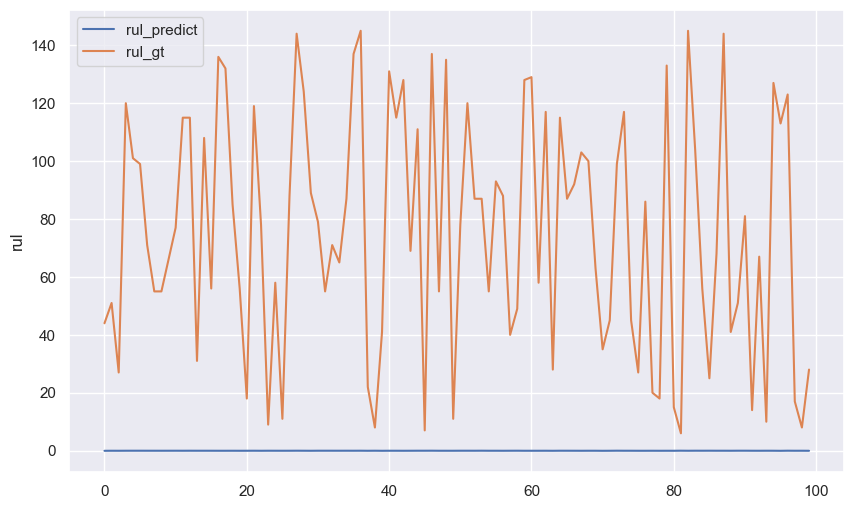

In [148]:
# [WriteCode]
test_loss, test_mae = model_lstm_rul.evaluate(seq_array_test_last, label_array_test_last)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")
rul = model_lstm_rul.predict(seq_array_test_last)
plt.figure(figsize=(10, 6))
plt.plot(rul, label='rul_predict')
plt.plot(label_array_test_last, label='rul_gt')
plt.ylabel('rul')
plt.legend()
plt.show()

#### Hyperparameter Optimisation

This involves finding the best network architecture (no. of layers, no. of nodes per layer, activations) and values for the learning rate, optimizer, dropout rate etc., even batch size and no. of epochs, parameters of the LSTM model for RUL regression.

Since a systematic search is highly computationally expensive, you will only design and implement an improved LSTM model with the **same** network architecture (no. and types of layers, no. of nodes per layer, activations) as the baseline LSTM model, but you are free to set different values for the other parameters (you may vary the value(s) of one or more parameters).

In the cell below, enter the improved LSTM model for RUL regression (named "model_lstm_rul_alt").

- Fit the model. Use validation_split = 0.05
- Use callback: "**keras.callbacks.TensorBoard(log_dir=get_run_logdir("run_lstm_rul_alt") , histogram_freq=1, write_graph= True, update_freq='epoch')**" to store the model training to Tensorboard log file "run_lstm_rul_alt" for visualization.
- Evaluate and print training data MAE.
- Evaluate and print test data MAE (use seq_array_test_last and label_array_test_last generated previously).

Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
165/165 [==============================] - 8s 39ms/step - loss: 11049.5410 - mae: 74.8500 - val_loss: 4244.6528 - val_mae: 44.4997
Epoch 2/100

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
165/165 [==============================] - 5s 33ms/step - loss: 4701.8237 - mae: 49.0056 - val_loss: 3835.7312 - val_mae: 41.9052
Epoch 3/100

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
165/165 [==============================] - 5s 32ms/step - loss: 4054.1934 - mae: 45.0404 - val_loss: 2885.5891 - val_mae: 36.2780
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
165/165 [==============================] - 6s 34ms/step - loss: 3831.4941 - mae: 43.3799 - val_loss: 4302.2573 - val_mae: 43.6078
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
165/165 [==============================] - 5s 32ms/step - loss: 3676.6033 - mae

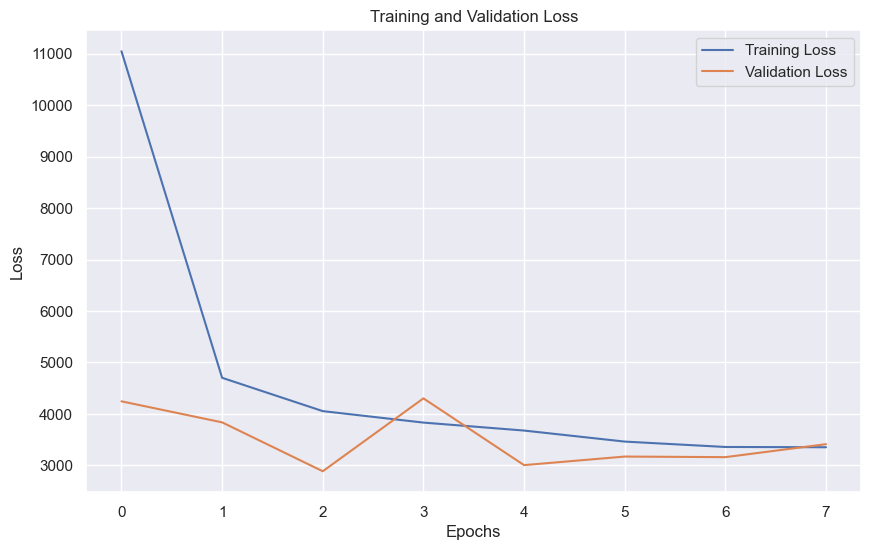

695/695 [==============================] - 3s 4ms/step - loss: 2954.7686 - mae: 36.2394
Training Loss: 2954.7685546875, Training MAE: 36.23941421508789
4/4 [==============================] - 0s 4ms/step - loss: 1683.4537 - mae: 28.9644
Test Loss: 1683.4537353515625, Test MAE: 28.96441078186035


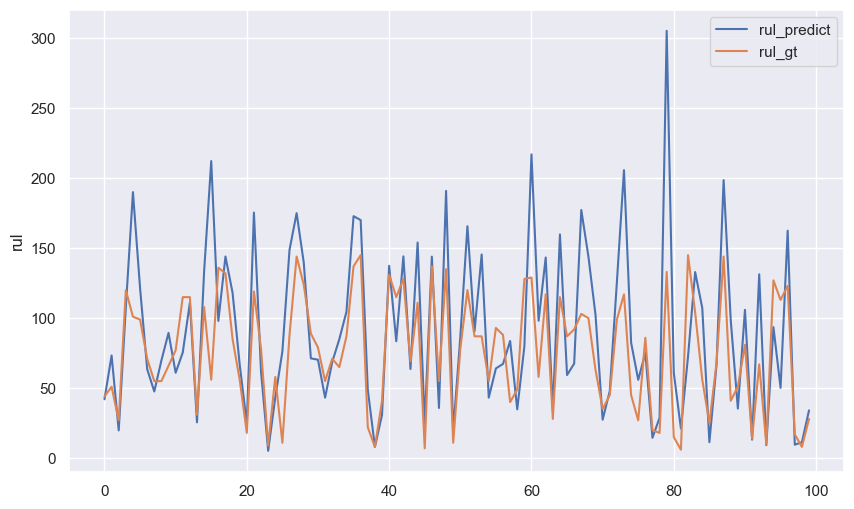

CPU times: total: 2min 39s
Wall time: 48.9 s


In [152]:
%%time
cb = keras.callbacks.TensorBoard(log_dir= get_run_logdir("run_lstm_rul_alt"), histogram_freq=1, write_graph= True, update_freq='epoch')

# [WriteCode]
model_lstm_rul_alt = Sequential()
model_lstm_rul_alt.add(LSTM(50, return_sequences=True, activation='relu', input_shape=(seq_array.shape[1], seq_array.shape[2]), kernel_regularizer=l1(0.01)))
model_lstm_rul_alt.add(Dropout(0.2))
model_lstm_rul_alt.add(LSTM(50, return_sequences=False, activation='relu', kernel_regularizer=l1(0.01)))
model_lstm_rul_alt.add(Dropout(0.2))
model_lstm_rul_alt.add(Dense(1))
'''model_lstm_rul = Sequential()
model_lstm_rul.add(LSTM(128, return_sequences=True, input_shape=(seq_array.shape[1], seq_array.shape[2]), activation='tanh'))
# model_lstm_rul.add(Dropout(0.2))
model_lstm_rul.add(LSTM(64, return_sequences=True, activation='tanh'))
# model_lstm_rul.add(Dropout(0.2))
# model_lstm_rul.add(LSTM(32, activation='tanh'))
# model_lstm_rul.add(Dropout(0.2))
# model_lstm_rul.add(Dense(96, activation='relu'))
# model_lstm_rul.add(Dropout(0.2))
model_lstm_rul.add(Dense(16, activation='relu'))
# model_lstm_rul.add(Dropout(0.2))
model_lstm_rul.add(Dense(1))'''



model_lstm_rul_alt.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

'''def lr_schedule(epoch):
    initial_lr = 0.01
    decay_rate = 0.9
    decay_step = 10
    return initial_lr * (decay_rate ** (epoch // decay_step))'''

def lr_schedule(epoch):
    if epoch < 5:
        return 0.001
    else:
        return 0.0001

early_stopping = EarlyStopping(monitor='val_loss',  
                   patience=5, 
                   verbose=True)    

lr_scheduler = LearningRateScheduler(lr_schedule, verbose=True)
history = model_lstm_rul_alt.fit(seq_array, label_array, epochs=100, batch_size=128, validation_split=0.05, callbacks=[lr_scheduler, early_stopping, cb])


# 绘制训练集和验证集的损失曲线
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show() 

train_loss, train_mae = model_lstm_rul_alt.evaluate(seq_array, label_array)
print(f"Training Loss: {train_loss}, Training MAE: {train_mae}")

test_loss, test_mae = model_lstm_rul_alt.evaluate(seq_array_test_last, label_array_test_last)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")
rul = model_lstm_rul_alt.predict(seq_array_test_last)
plt.figure(figsize=(10, 6))
plt.plot(rul, label='rul_predict')
plt.plot(label_array_test_last, label='rul_gt')
plt.ylabel('rul')
plt.legend()
plt.show()

### Comparing CNN 1D and LSTM models for RUL Regression
Using a Pandas dataframe, combine the results obtained for RUL regression such as MAE for test data of the CNN, LSTM, alt-CNN and alt-LSTM models for RUL regression.

Display this dataframe.

In [158]:
# [WriteCode]
model_cnn_rul_test_loss, model_cnn_rul_test_mae = model_cnn_rul.evaluate(seq_array_test_last, label_array_test_last)
model_lstm_rul_test_loss, model_lstm_rul_test_mae = model_lstm_rul.evaluate(seq_array_test_last, label_array_test_last)
model_cnn_rul_alt_test_loss, model_cnn_rul_alt_test_mae = model_cnn_rul_alt.evaluate(seq_array_test_last, label_array_test_last)
model_lstm_rul_alt_test_loss, model_lstm_rul_alt_test_mae = model_lstm_rul_alt.evaluate(seq_array_test_last, label_array_test_last)

# model_cnn_rul_test_loss, model_cnn_rul_test_mae = [0, 0]
# model_cnn_rul_alt_test_loss, model_cnn_rul_alt_test_mae = [0, 0]

data = {'Model': ['CNN', 'LSTM', 'CNN-alt', 'LSTM-alt'],
        'MSE Loss': [model_cnn_rul_test_loss, model_lstm_rul_test_loss, model_cnn_rul_alt_test_loss, model_lstm_rul_alt_test_loss],
        'MAE': [model_cnn_rul_test_mae, model_lstm_rul_test_mae, model_cnn_rul_alt_test_mae, model_lstm_rul_alt_test_mae]}
df = pd.DataFrame(data)
print(df)

4/4 [==============================] - 0s 4ms/step - loss: 1683.4537 - mae: 28.9644
      Model     MSE Loss        MAE
0       CNN  7329.233887  74.908615
1      LSTM  7390.816895  75.348076
2   CNN-alt  7355.478027  75.102859
3  LSTM-alt  1683.453735  28.964411


## Visualization with TensorBoard

Many quantities such as loss function and performance metrics are saved while training the models and can be visualized using TensorBoard.

Use these visualizations to provide the evidence in your answers to the questions in Section 7.1 of the assignment document.

Make sure you select the correct information to visualize and compare. 

*Note*: Results from different runs are saved in separate time-stamped folders. 

In [154]:
%load_ext tensorboard
%tensorboard --logdir=./eec4400_logs --port=6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 8), started 3 days, 21:55:14 ago. (Use '!kill 8' to kill it.)